In [1]:
%matplotlib inline
import sys, os
sys.path.append(os.path.join(os.environ['ATS_SRC_DIR'],'tools', 'utils'))
import ats_xdmf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def modeled(directory,t_sel,por):
    vis = ats_xdmf.VisFile(directory, time_unit='hr')
    vis.loadMesh(columnar=True)
    time = vis.times
    z = vis.centroids[:,-1]*100
    cv = vis.getArray('cell_volume')[0]
    wc,rho_l,T,theta_l,theta_i,theta_t = (np.zeros((len(t_sel),len(z))) for i in range(6))
    for i in range(len(t_sel)):
        wc[i] = vis.getArray('water_content')[t_sel[i]]
        rho_l[i] = vis.getArray('molar_density_liquid')[t_sel[i]]
        T[i] = vis.getArray('temperature')[t_sel[i]]-273.15
        theta_l[i] = vis.getArray('saturation_liquid')[t_sel[i]]*por
        theta_i[i] = vis.getArray('saturation_ice')[t_sel[i]]*por
        theta_t[i] = wc[i]/rho_l[i]/cv
        
    #for initial condition check only
#     wci = sum(vis.getArray('water_content')[0]/vis.getArray('molar_density_liquid')[0])/sum(cv)
#     print(wci)
    return theta_t,theta_i,T,z

# Mizoguchi (1990) experiment data: total water content

In [3]:
dataset_Mizoguchi1990=pd.read_excel('Mizoguchi(1990)_labexp_data.xlsx',
                                    sheet_name='Mizoguchi1990',header=[0,1])

wct_12 = dataset_Mizoguchi1990.iloc[:,0:2].values
wct_24 = dataset_Mizoguchi1990.iloc[:,3:5].values
wct_50 = dataset_Mizoguchi1990.iloc[:,6:8].values
wct_exp = [wct_12,wct_24,wct_50]

# Modeled data

Output includes:   
(1) total water content ($\mathrm{m}^3/\mathrm{m}^3$)  
(2) ice content ($\mathrm{m}^3/\mathrm{m}^3$)  
(3) temperature (°C)  
(4) vertical location (cm)

In [4]:
t_select = [12,24,50]        #selected time point in paper
por = 0.535

directory_cryo = "cryos_labexpVSmodel/model_cryosuction"
solution_cryo = modeled(directory_cryo,t_select,por) 

directory_no = "cryos_labexpVSmodel/model_nocryosuction"
solution_no = modeled(directory_no,t_select,por)

# solution_cryo = [tot_cryo,ice_cryo,T_cryo,z_cryo]
# solution_no = [tot_no,ice_no,T_no,z_no]

# Experiment vs. model with/no cryosuction

In [5]:
# plot total water content, ice content, and temperature

def plot(solution,t,axs,color,label,fontsize=14):
    
    # solution=[tot,ice,T,z]
    solution_name = ['total water content','ice content','temperature']
    tid = t_select.index(t)
    for i in range(3):
        axs[i].plot(solution[i][tid],solution[-1],color=color,label=label)
        axs[i].set_yticks(range(0,22,2))
        axs[i].set_ylim(0,20)
        axs[i].set_ylabel('Elevetion (cm)',fontsize=fontsize)
        axs[i].set_xlabel(solution_name[i],fontsize=fontsize)
        
    for i in range(2):
        axs[i].set_xticks(np.arange(0,0.6,0.1))
        axs[i].set_xlim(0,0.5)
    axs[2].set_xticks(np.arange(-6,7,2))
    axs[2].set_xlim(-6,6)

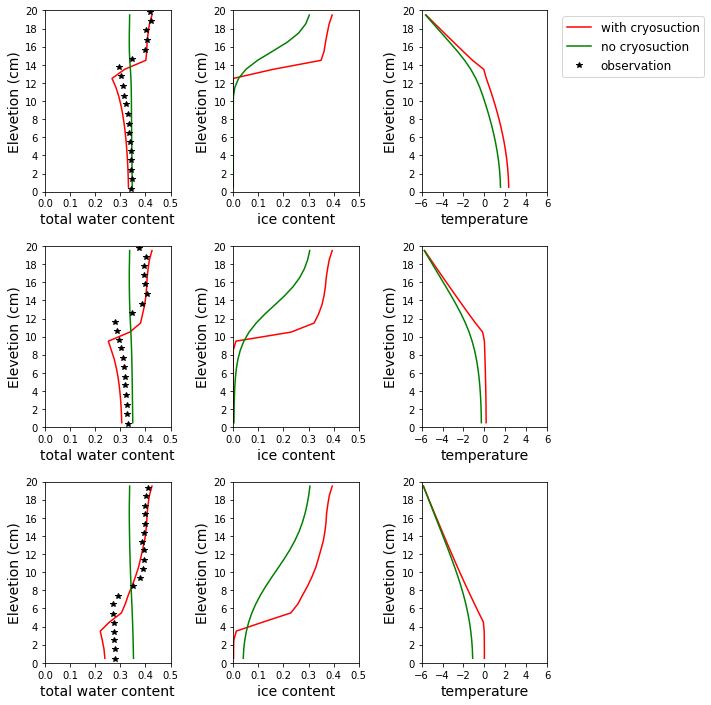

In [6]:
fig, axs = plt.subplots(len(t_select),3,figsize=(9,12))

for i in range(len(t_select)):
    plot(solution_cryo,t_select[i],axs[i],color='r',label='with cryosuction')
    plot(solution_no,t_select[i],axs[i],color='g',label='no cryosuction')
    axs[i][0].plot(wct_exp[i][:,0],wct_exp[i][:,1],'k*',label='observation')

handles,labels = axs[0][0].get_legend_handles_labels()
axs[0][0].legend(handles,labels,fontsize=12,bbox_to_anchor=[5.3,1])    
plt.subplots_adjust(wspace=0.5, hspace=0.3)